## Aprendizado Multiobjetivo em Modelos Supervisionados

**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres

---

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, precision_score, recall_score, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

---

### 1. Base de Dados:
Escolher três base de dados de regressão ou classificação do repositório UCI Machine Learning Repository (https://archive.ics.uci.edu/) ou outra fonte confiável.

Datasets:
- **Regressão**: Student Performance
- **Classificação**: Spambase
- Concrete Compressive Strength

In [9]:
# ------------------ SPAMBASE ------------------

# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
print(spambase.metadata) 
  
# variable information 
print(spambase.variables) 

  

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [10]:
# -------------------------  Preprocess dataset -------------------------
# Juntar X e y primeiro para garantir consistência
df = pd.concat([X, y], axis=1)

# Verificar e tratar valores faltantes
print("Valores faltantes antes do tratamento:")
print(df.isnull().sum())

# Preencher valores faltantes (se necessário)
df.fillna(df.mean(), inplace=True)

# Verificar se ainda há valores faltantes
print("\nValores faltantes após o tratamento:")
print(df.isnull().sum().sum())

# Separar novamente X e y após o tratamento
X = df.drop(columns=y.columns)
y = df[y.columns]

# Verificar consistência no tamanho
print("\nNúmero de amostras em X e y:")
print(len(X), len(y)) 


Valores faltantes antes do tratamento:
word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
w

In [11]:
# ------------------------- Data Preparation -------------------------
# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

In [12]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\nShapes após train/test split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


print("\nValores NaN em X_train:", X_train.isna().sum().sum())
print("Valores NaN em y_train:", y_train.isna().sum().sum())


Shapes após train/test split:
X_train: (3220, 57), y_train: (3220, 1)
X_test: (1381, 57), y_test: (1381, 1)

Valores NaN em X_train: 0
Valores NaN em y_train: 0


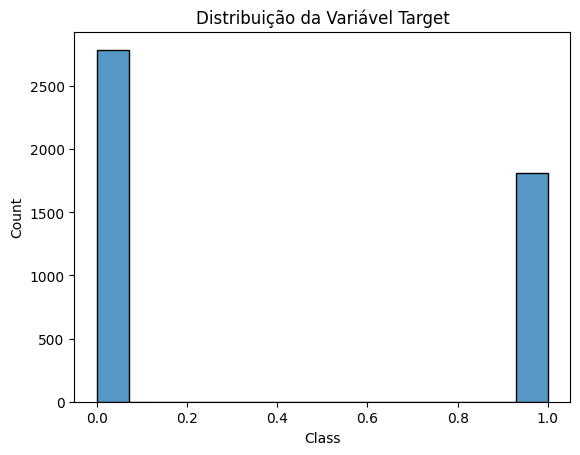

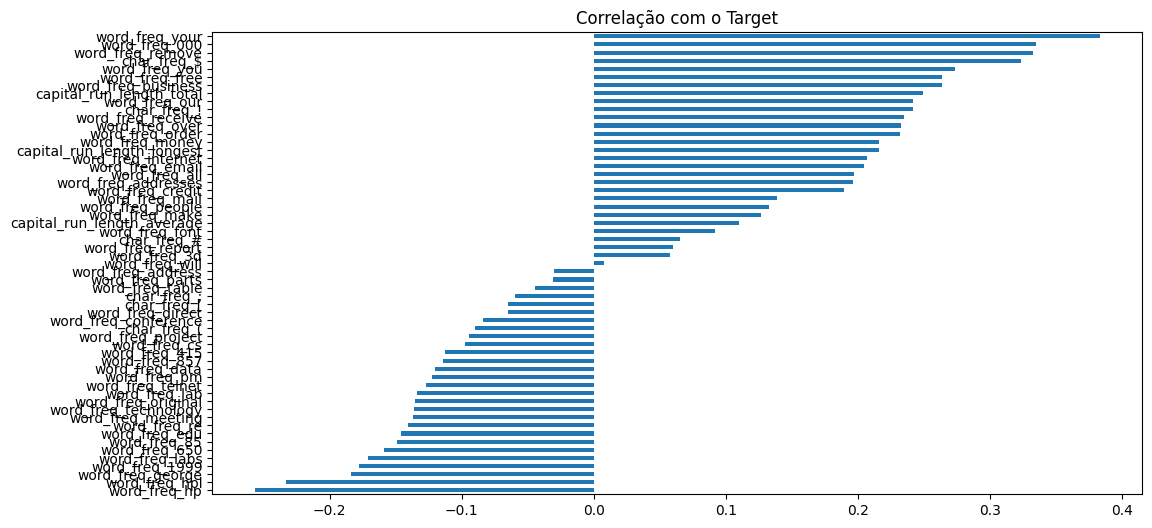

In [14]:
# Verificar distribuição do target

sns.histplot(y.iloc[:, 0]) # y.iloc[:, 0]
plt.title('Distribuição da Variável Target')
plt.show()

# Correlação entre features numéricas e target
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_features].corrwith(y.iloc[:, 0])
plt.figure(figsize=(12, 6))
correlations.sort_values().plot.barh()
plt.title('Correlação com o Target')
plt.show()

---

### 2. Modelagem com Algoritmos Supervisionados:
Utilizar os três ou mais
- Rede Neural (MLP)
- Árvore de Decisão
- Random Forest

Explorar diferentes arquiteturas ou configurações (como profundidade, número de neurônios, número de árvores etc.) para gerar modelos com diferentes graus de complexidade.

In [ ]:
# ------------------------- Random Forest Classfier -------------------------

n_estimators_list = [50, 100, 200]      # Número de árvores
max_depth_list = [5, 10, 30, None]      # Profundidade máxima

results_rf = []

# Verificar e garantir que y_train seja 1D
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.values.ravel()

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        RFC = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=5, 
            n_jobs=1,
            random_state=42
        )
        RFC.fit(X_train, y_train)
        
        # Métricas
        y_pred = RFC.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Complexidade
        avg_depth = np.mean([tree.tree_.max_depth for tree in RFC.estimators_])
        n_params = sum(tree.tree_.n_node_samples.size for tree in RFC.estimators_)
        
        results_rf.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'avg_depth': avg_depth,
            'n_params': n_params,
            'Accuracy': acc,
            'F1_score': f1
        })

        # Guardando features relevantes
        feature_importance = RFC.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\nFeatures mais relevantes para Random Forest - Profundidade máxima {max_depth} | Árvores {n_estimators}:")
        print(importance_df.head())

        # Plotagem das predições
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Spam', 'Spam'], 
                yticklabels=['Não Spam', 'Spam'])
        plt.title(f'Random Forest - n_estimators={n_estimators}, max_depth={max_depth}\nAcurácia: {acc:.2f}, F1: {f1:.2f}')
        plt.ylabel('Verdadeiro')
        plt.xlabel('Predito')
        plt.show()




Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 50:
                       Feature  Importance
52                 char_freq_$    0.152387
51                 char_freq_!    0.137603
6             word_freq_remove    0.115020
15              word_freq_free    0.085429
55  capital_run_length_longest    0.060493

Features mais relevantes para Random Forest - Profundidade máxima 10 | Árvores 50:
                       Feature  Importance
52                 char_freq_$    0.132945
51                 char_freq_!    0.129372
6             word_freq_remove    0.103732
15              word_freq_free    0.079619
55  capital_run_length_longest    0.061142

Features mais relevantes para Random Forest - Profundidade máxima 30 | Árvores 50:
                       Feature  Importance
51                 char_freq_!    0.134713
52                 char_freq_$    0.134560
6             word_freq_remove    0.099020
15              word_freq_free    0.082292
55  capital_run_le

In [26]:
# ------------------------- Decision Tree Classifier -------------------------

max_depth_list = [3, 5, 10, 20, None]
results_dt = []

for max_depth in max_depth_list:
    DTC = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=5, 
        random_state=42
    )
    DTC.fit(X_train, y_train)
    
    # Métricas
    y_pred = DTC.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Complexidade
    n_nodes = DTC.tree_.node_count
    depth = DTC.tree_.max_depth
    
    results_dt.append({
        'max_depth_set': max_depth,
        'actual_depth': depth,
        'n_nodes': n_nodes,
        'Accuracy': acc,
        'F1_score': f1
        
    })

    # Guardando features relevantes
    feature_importance = DTC.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nFeatures mais relevantes para Decision Tree - Profundidade máxima {max_depth}:")
    print(importance_df.head())


    """
    # Plotagem das predições

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Spam', 'Spam'], 
                yticklabels=['Não Spam', 'Spam'])
    plt.title(f'Árvore de Decisão - Profundidade Max {max_depth}\nAcurácia: {acc:.2f}, F1: {f1:.2f}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

    """



Features mais relevantes para Decision Tree - Profundidade máxima 3:
             Feature  Importance
52       char_freq_$    0.524758
6   word_freq_remove    0.250041
51       char_freq_!    0.112022
24      word_freq_hp    0.076648
45     word_freq_edu    0.023394

Features mais relevantes para Decision Tree - Profundidade máxima 5:
                       Feature  Importance
52                 char_freq_$    0.450273
6             word_freq_remove    0.221228
51                 char_freq_!    0.096122
24                word_freq_hp    0.065768
54  capital_run_length_average    0.055227

Features mais relevantes para Decision Tree - Profundidade máxima 10:
                       Feature  Importance
52                 char_freq_$    0.394047
6             word_freq_remove    0.193803
51                 char_freq_!    0.094145
24                word_freq_hp    0.060892
54  capital_run_length_average    0.049717

Features mais relevantes para Decision Tree - Profundidade máxima 20:
    


=== Treinando modelo com 10 neurônios ===

Top 5 features mais relevantes:
                       Feature  Importance
54  capital_run_length_average    1.229901
26            word_freq_george    1.174835
45               word_freq_edu    0.813874
37             word_freq_parts    0.804806
24                word_freq_hp    0.688549


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


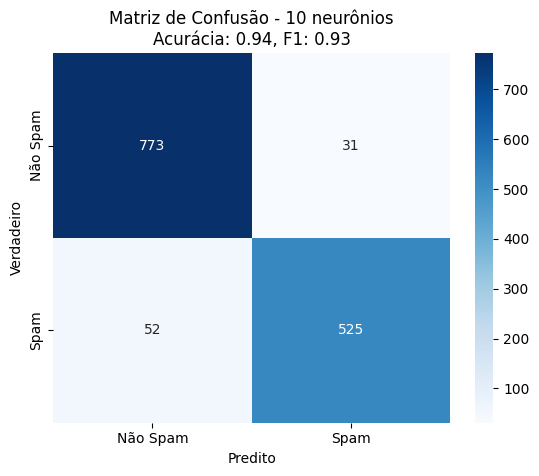


=== Treinando modelo com 20 neurônios ===

Top 5 features mais relevantes:
                       Feature  Importance
54  capital_run_length_average    0.948471
26            word_freq_george    0.786424
45               word_freq_edu    0.662869
24                word_freq_hp    0.544668
44                word_freq_re    0.537979


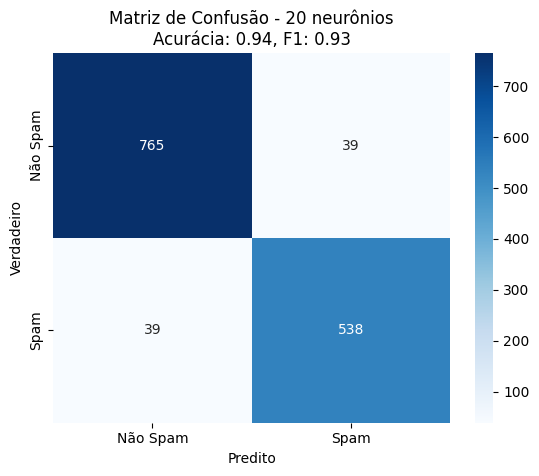


=== Treinando modelo com 30 neurônios ===

Top 5 features mais relevantes:
                       Feature  Importance
26            word_freq_george    0.712336
54  capital_run_length_average    0.682087
45               word_freq_edu    0.472524
37             word_freq_parts    0.462598
27               word_freq_650    0.442324


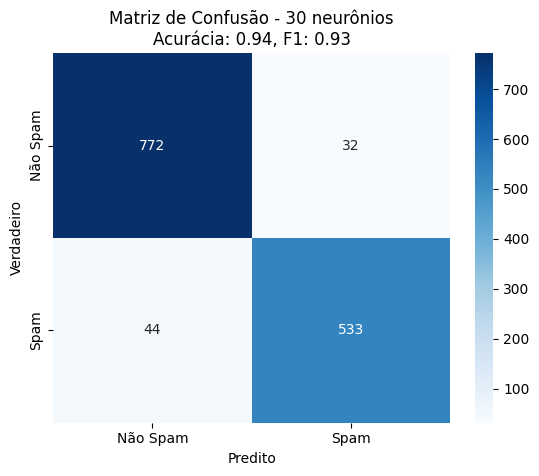


=== Treinando modelo com 50 neurônios ===

Top 5 features mais relevantes:
                       Feature  Importance
45               word_freq_edu    0.446402
26            word_freq_george    0.415308
54  capital_run_length_average    0.414405
24                word_freq_hp    0.362777
6             word_freq_remove    0.317055


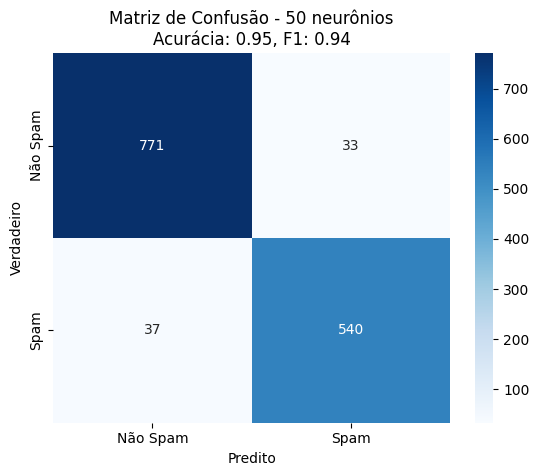


=== Treinando modelo com 100 neurônios ===

Top 5 features mais relevantes:
                       Feature  Importance
54  capital_run_length_average    0.373607
45               word_freq_edu    0.356451
26            word_freq_george    0.340020
37             word_freq_parts    0.255715
24                word_freq_hp    0.255321


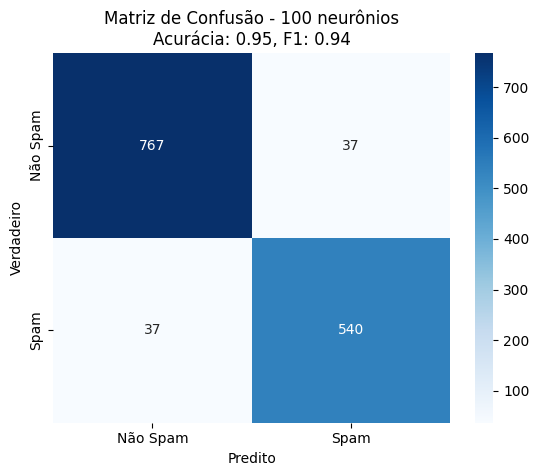

In [24]:
# ------------------------- MLP Classifier -------------------------
hidden_layers = [10, 20, 30, 50, 100]  # Número de neurônios nas camadas ocultas
results_nn = []

def count_mlp_params(mlp):
    n_params = 0
    for weights in mlp.coefs_:
        n_params += weights.size
    for bias in mlp.intercepts_:
        n_params += bias.size
    return n_params

for layer in hidden_layers:
    print(f"\n=== Treinando modelo com {layer} neurônios ===")
    
    model = MLPClassifier(
        hidden_layer_sizes=(layer,), 
        max_iter=1000,
        solver='adam', 
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Métricas de classificação
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Complexidade
    n_params = count_mlp_params(model)
    
    results_nn.append({
        'hidden_layers': layer,
        'n_params': n_params,
        'Accuracy': acc,
        'F1_score': f1
    })

    # Features relevantes
    weights = model.coefs_[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,  # Use seus nomes de features aqui
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 features mais relevantes:")
    print(importance_df.head())
    
    # Plot da matriz de confusão (melhor para classificação)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Spam', 'Spam'], 
                yticklabels=['Não Spam', 'Spam'])
    plt.title(f'Matriz de Confusão - {layer} neurônios\nAcurácia: {acc:.2f}, F1: {f1:.2f}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()




---

### 3. Critérios de Avaliação:
**Erro de predição**: utilizar métricas como MSE, RMSE, acurácia, F1-score, conforme o tipo de problema.

**Complexidade do modelo**:
* **Redes neurais**: número de parâmetros treináveis.
* **Árvores de decisão**: profundidade ou número de nós.
* **Random Forest**: número de árvores e profundidade média.

In [28]:
# ------------------------- Visualização das métricas -------------------------
print("\nResultados da MLP:")
df_results_nn = pd.DataFrame(results_nn)
print(df_results_nn)

print("\nResultados do Random Forest:")
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf.sort_values('Accuracy', ascending=False))

print("\nResultados do Decision Tree:")
df_results_dt = pd.DataFrame(results_dt)
print(df_results_dt)


Resultados da MLP:
   hidden_layers  n_params  Accuracy  F1_score
0             10       591  0.939899  0.926743
1             20      1181  0.943519  0.932409
2             30      1771  0.944967  0.933450
3             50      2951  0.949312  0.939130
4            100      5901  0.946416  0.935875

Resultados do Random Forest:
    n_estimators  max_depth  avg_depth  n_params  Accuracy  F1_score
10           200       30.0     20.710     48070  0.950036  0.938776
3             50        NaN     20.920     11990  0.948588  0.937335
11           200        NaN     20.715     48060  0.948588  0.936889
2             50       30.0     20.900     12000  0.948588  0.937335
7            100        NaN     20.670     23972  0.944967  0.932624
6            100       30.0     20.660     23982  0.944967  0.932624
5            100       10.0     10.000     15824  0.939899  0.925959
1             50       10.0     10.000      7896  0.939899  0.925827
9            200       10.0     10.000     3178

In [29]:
# ------------------------- Análise Multiobjetivo -------------------------

# Adicionar coluna de modelo para cada DataFrame
df_results_nn['model'] = 'MLP Classifier'
df_results_rf['model'] = 'Random Forest'
df_results_dt['model'] = 'Decision Tree'

# Selecionando apenas colunas relevantes
df_results_dt = df_results_dt[['n_nodes', 'Accuracy', 'F1_score']]
df_results_dt['n_params'] = df_results_dt['n_nodes']
df_results_rf = df_results_rf[['n_params', 'Accuracy', 'F1_score']]
df_results_nn = df_results_nn[['n_params', 'Accuracy', 'F1_score']]

# Unificando resultados em um dataframe
df_all = pd.concat([
    df_results_nn.assign(model='MLP Classifier'),
    df_results_rf.assign(model='Random Forest'),
    df_results_dt.assign(model='Decision Tree')
], ignore_index=True)

---

### 4. Otimização Multiobjetivo:
Utilizar alguma abordagem para encontrar modelos que equilibrem desempenho e complexidade, como:
- Busca em grade ou aleatória com análise biobjetiva.
- Algoritmos evolutivos (como NSGA-II, se desejado).
- Análise e visualização da fronteira de Pareto.

In [30]:
def is_pareto_efficient(df):
    data = df[['n_params', 'Accuracy']].copy()
    # Muda R² para -R² para poder usar algoritmo de minimização
    data['Accuracy'] = -data['Accuracy']
    # Convertendo para numpy array
    costs = data.to_numpy()
    
    # Inicializa um array booleano para identificar soluções eficientes
    is_efficient = np.ones(costs.shape[0], dtype=bool)

    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Verifica se há outras soluções que são melhores ou iguais em todos os objetivos
            # descarta soluções que são dominadas
            is_efficient[is_efficient] = (
                np.any(costs[is_efficient] < c, axis=1) | 
                np.all(costs[is_efficient] == c, axis=1)
            )
            is_efficient[i] = True # garante que a solução atual é considerada eficiente
    return is_efficient


df_all['pareto'] = is_pareto_efficient(df_all)
pareto_df = df_all[df_all['pareto']] # DataFrame com soluções eficientes de Pareto


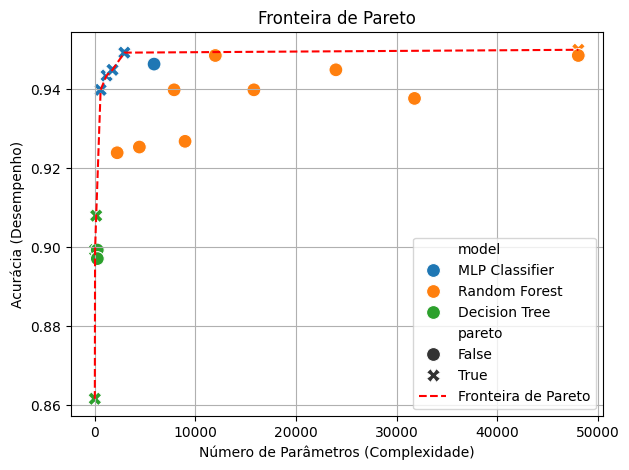

In [31]:
# ------------------------- Visualização da Fronteira de Pareto -------------------------
sns.scatterplot(
    data=df_all, 
    x='n_params', 
    y='Accuracy', 
    hue='model', 
    style='pareto', 
    s=100)

pareto_sorted = pareto_df.sort_values('n_params')

plt.plot(
    pareto_sorted['n_params'], 
    pareto_sorted['Accuracy'], 
    linestyle='--', 
    color='red', 
    label='Fronteira de Pareto')


plt.xlabel('Número de Parâmetros (Complexidade)')
plt.ylabel('Acurácia (Desempenho)')
plt.title('Fronteira de Pareto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()